<a href="https://colab.research.google.com/github/Bosy-Ayman/DSAI-403-Nature-Inspired-Computation/blob/main/NIC_LAB4_Swarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import gc
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.utils import to_categorical
from collections import deque
import copy
import matplotlib.pyplot as plt


In [ ]:

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Particle Swarm Optimization (PSO)


In [ ]:
def generate_labels(n_samples, height, width, num_classes=4):
    labels = np.random.randint(0, num_classes, (n_samples, height, width))
    y_onehot = np.zeros((n_samples, height, width, num_classes))
    for i in range(n_samples):
        y_onehot[i] = to_categorical(labels[i], num_classes=num_classes)
    return y_onehot.astype(np.float32)

IMG_SIZE = 64
X_train = np.random.rand(8, IMG_SIZE, IMG_SIZE, 2).astype(np.float32)
Y_train = generate_labels(8, IMG_SIZE, IMG_SIZE)
X_val = np.random.rand(4, IMG_SIZE, IMG_SIZE, 2).astype(np.float32)
Y_val = generate_labels(4, IMG_SIZE, IMG_SIZE)

train_gen = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(2)
val_gen = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(2)

# Metrics
def dice_coef(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    num_classes = 4
    dice = 0.0
    for c in range(num_classes):
        y_true_c = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred, c), tf.float32)
        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
        dice += (2. * intersection + 1e-7) / (union + 1e-7)
    return dice / num_classes

def precision(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    num_classes = 4
    prec = 0.0
    for c in range(num_classes):
        y_true_c = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred, c), tf.float32)
        tp = tf.reduce_sum(y_true_c * y_pred_c)
        fp = tf.reduce_sum(y_pred_c * (1 - y_true_c))
        prec += tp / (tp + fp + 1e-7)
    return prec / num_classes

def sensitivity(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    num_classes = 4
    sens = 0.0
    for c in range(num_classes):
        y_true_c = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred, c), tf.float32)
        tp = tf.reduce_sum(y_true_c * y_pred_c)
        fn = tf.reduce_sum(y_true_c * (1 - y_pred_c))
        sens += tp / (tp + fn + 1e-7)
    return sens / num_classes

def specificity(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    num_classes = 4
    spec = 0.0
    for c in range(num_classes):
        y_true_c = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred, c), tf.float32)
        tn = tf.reduce_sum((1 - y_true_c) * (1 - y_pred_c))
        fp = tf.reduce_sum((1 - y_true_c) * y_pred_c)
        spec += tn / (tn + fp + 1e-7)
    return spec / num_classes


In [ ]:

def build_unet(input_layer, ker_init, dropout):
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(input_layer)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    drop4 = Dropout(dropout)(conv4)

    # Decoder
    up1 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D((2,2))(drop4))
    merge1 = concatenate([conv3, up1])
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)

    up2 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D((2,2))(conv5))
    merge2 = concatenate([conv2, up2])
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge2)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up3 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D((2,2))(conv6))
    merge3 = concatenate([conv1, up3])
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    output = Conv2D(4, (1,1), activation='softmax')(conv7)
    return Model(inputs=input_layer, outputs=output)


# Particle Swarm Optimization (PSO)


In [ ]:

class Particle:
    def __init__(self, lr, dropout):
        self.position = np.array([lr, dropout])
        self.velocity = np.zeros(2)
        self.best_pos = self.position.copy()
        self.best_score = -np.inf  # For maximization

def evaluate_pso(lr, dropout):
    """Train the U-Net briefly and return validation accuracy."""
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    ker_init = tf.keras.initializers.HeNormal()
    model = build_unet(input_layer, ker_init, dropout)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy', dice_coef, precision, sensitivity, specificity]
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=1,
        steps_per_epoch=5,
        verbose=0
    )

    val_acc = float(history.history['val_accuracy'][-1])

    K.clear_session()
    del model, history
    gc.collect()

    return val_acc

In [ ]:

def pso_optimize(n_particles=3, n_iter=5, lr_bounds=(1e-4, 1e-3), dropout_bounds=(0.1, 0.5)):
    w, c1, c2 = 0.7, 1.5, 1.5
    swarm = [Particle(random.uniform(*lr_bounds), random.uniform(*dropout_bounds)) for _ in range(n_particles)]
    gbest_pos = None
    gbest_score = -np.inf
    pso_history = []

    for iteration in range(n_iter):
        print(f"\n=== PSO Iteration {iteration+1}/{n_iter} ===")
        iteration_best = -np.inf
        for i, p in enumerate(swarm):
            score = evaluate_pso(p.position[0], p.position[1])
            print(f"Particle {i+1}: lr={p.position[0]:.6f}, dropout={p.position[1]:.3f}, val_acc={score:.4f}")

            if score > p.best_score:
                p.best_score = score
                p.best_pos = p.position.copy()
            if score > iteration_best:
                iteration_best = score
            if score > gbest_score:
                gbest_score = score
                gbest_pos = p.position.copy()

            K.clear_session()
            gc.collect()

        pso_history.append((iteration + 1, gbest_score))
        print(f"PSO Best so far: {gbest_score:.4f}")

        for p in swarm:
            r1, r2 = random.random(), random.random()
            p.velocity = w * p.velocity + c1 * r1 * (p.best_pos - p.position) + c2 * r2 * (gbest_pos - p.position)
            p.position += p.velocity
            p.position[0] = np.clip(p.position[0], *lr_bounds)
            p.position[1] = np.clip(p.position[1], *dropout_bounds)

    return gbest_pos, gbest_score, pso_history

print("Running PSO...")
best_pos, best_score_pso, pso_history = pso_optimize()
print(f"\nPSO Best Hyperparameters: lr={best_pos[0]:.6f}, dropout={best_pos[1]:.3f}")
print(f"PSO Best Validation Accuracy: {best_score_pso:.4f}")


Running PSO...

=== PSO Iteration 1/5 ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Particle 1: lr=0.000675, dropout=0.110, val_acc=0.2488
Particle 2: lr=0.000348, dropout=0.189, val_acc=0.2557
Particle 3: lr=0.000763, dropout=0.371, val_acc=0.2460
PSO Best so far: 0.2557

=== PSO Iteration 2/5 ===
Particle 1: lr=0.000379, dropout=0.182, val_acc=0.2480
Particle 2: lr=0.000348, dropout=0.189, val_acc=0.2438
Particle 3: lr=0.000501, dropout=0.257, val_acc=0.2507
PSO Best so far: 0.2557

=== PSO Iteration 3/5 ===
Particle 1: lr=0.000466, dropout=0.161, val_acc=0.2503
Particle 2: lr=0.000348, dropout=0.189, val_acc=0.2469
Particle 3: lr=0.000297, dropout=0.167, val_acc=0.2515
PSO Best so far: 0.2557

=== PSO Iteration 4/5 ===
Particle 1: lr=0.000504, dropout=0.151, val_acc=0.2527
Particle 2: lr=0.000348, dropout=0.189, val_acc=0.2482
Particle 3: lr=0.000202, dropout=0.126, val_acc=0.2519
PSO Best so far: 0.2557

=== PSO Iteration 5/5 ===
Particle 1: lr=0.000463, dropout=0.161, val_acc=0.2522
Particle 2: lr=0.000348, dropout=0.189, val_acc=0.2505
Particle 3: lr=0.000196, d

# TABU Search


In [ ]:
def random_initial_solution(search_space, seed=None):
    if seed is not None:
        random.seed(seed)
    solution = {}
    for k, vals in search_space.items():
        solution[k] = random.choice(vals)
    return solution


In [ ]:
def neighborhood_of(solution, search_space):
    neigh = []
    for param, vals in search_space.items():
        for v in vals:
            if v != solution[param]:
                new_sol = copy.deepcopy(solution)
                new_sol[param] = v
                move = (param, v)
                neigh.append((new_sol, move))
    return neigh

In [ ]:

def evaluate_model(params):
    lr = params['learning_rate']
    dropout = params['dropout_rate']
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    ker_init = tf.keras.initializers.HeNormal()
    model = build_unet(input_layer, ker_init, dropout)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy', dice_coef, precision, sensitivity, specificity]
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=1,
        steps_per_epoch=4,
        verbose=0
    )

    val_acc = float(history.history['val_accuracy'][-1])

    K.clear_session()
    del model, history
    gc.collect()

    return val_acc

In [ ]:

def tabu_search(search_space, evaluate_fn, max_iters=20, tabu_size=7, seed=123, verbose=True):
    random.seed(seed)

    current = random_initial_solution(search_space, seed=seed)
    current_score = evaluate_fn(current)
    best = copy.deepcopy(current)
    best_score = current_score

    tabu_list = deque(maxlen=tabu_size)

    eval_cache = {tuple(sorted(current.items())): current_score}

    history = []
    if verbose:
        print(f"Initial solution: {current} -> val_acc={current_score:.4f}")

    # Add initial to history
    history.append({
        "iter": 0,
        "current": copy.deepcopy(current),
        "current_score": current_score,
        "best": copy.deepcopy(best),
        "best_score": best_score,
        "move": None,
        "used_aspiration": False,
        "tabu_list": list(tabu_list)
    })

    for it in range(1, max_iters+1):
        neigh = neighborhood_of(current, search_space)

        candidates = []
        for sol, move in neigh:
            key = tuple(sorted(sol.items()))
            if key in eval_cache:
                val_acc = eval_cache[key]
            else:
                val_acc = evaluate_fn(sol)
                eval_cache[key] = val_acc
            candidates.append((sol, move, val_acc))

        candidates.sort(key=lambda x: x[2], reverse=True)

        selected = None
        for sol, move, val_acc in candidates:
            if move in tabu_list:
                if val_acc > best_score:
                    selected = (sol, move, val_acc, True)
                    break
                else:
                    continue
            else:
                selected = (sol, move, val_acc, False)
                break

        if selected is None:
            sol, move, val_acc = candidates[0]
            selected = (sol, move, val_acc, True)

        new_sol, move_taken, new_score, used_aspiration = selected

        tabu_list.append(move_taken)

        current = new_sol
        current_score = new_score

        if current_score > best_score:
            best_score = current_score
            best = copy.deepcopy(current)
            improved = True
        else:
            improved = False

        history.append({
            "iter": it,
            "current": copy.deepcopy(current),
            "current_score": current_score,
            "best": copy.deepcopy(best),
            "best_score": best_score,
            "move": move_taken,
            "used_aspiration": used_aspiration,
            "tabu_list": list(tabu_list)
        })

        if verbose:
            asp_txt = " (aspiration)" if used_aspiration else ""
            imp_txt = " IMPROVED!" if improved else ""
            print(f"[Iter {it}] move: {move_taken}, val_acc={current_score:.4f}{asp_txt}{imp_txt} -> best={best_score:.4f}")

    if verbose:
        print("Tabu Search finished.")
        print(f"Best: {best} -> val_acc={best_score:.4f}")

    return best, best_score, history

# Define search space for TABU
search_space = {
    "learning_rate": [1e-4, 1e-3, 5e-3],
    "dropout_rate": [0.1, 0.3, 0.5]
}

print("\nRunning TABU...")
start_time = time.time()
best_params, best_score_tabu, tabu_history = tabu_search(
    search_space=search_space,
    evaluate_fn=evaluate_model,
    max_iters=5,
    tabu_size=5,
    seed=seed,
    verbose=True
)
elapsed = time.time() - start_time
print(f"\nTotal time for Tabu: {elapsed:.1f}s")
print("Tabu Best hyperparameters found:", best_params)
print("Tabu Best validation accuracy:", best_score_tabu)



Running TABU...
Initial solution: {'learning_rate': 0.005, 'dropout_rate': 0.1} -> val_acc=0.2543
[Iter 1] move: ('dropout_rate', 0.3), val_acc=0.2540 -> best=0.2543
[Iter 2] move: ('learning_rate', 0.0001), val_acc=0.2592 IMPROVED! -> best=0.2592
[Iter 3] move: ('learning_rate', 0.005), val_acc=0.2540 -> best=0.2592
[Iter 4] move: ('dropout_rate', 0.1), val_acc=0.2543 -> best=0.2592
[Iter 5] move: ('learning_rate', 0.001), val_acc=0.2488 -> best=0.2592
Tabu Search finished.
Best: {'learning_rate': 0.0001, 'dropout_rate': 0.3} -> val_acc=0.2592

Total time for Tabu: 142.9s
Tabu Best hyperparameters found: {'learning_rate': 0.0001, 'dropout_rate': 0.3}
Tabu Best validation accuracy: 0.25921630859375


# Plot comparison


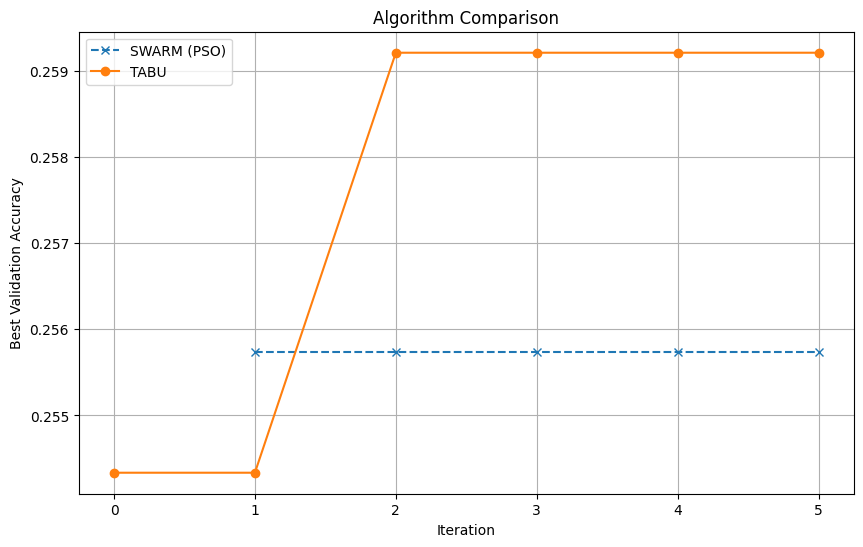

In [ ]:

pso_iterations, pso_accuracies = zip(*pso_history)
tabu_iterations = [h["iter"] for h in tabu_history]
tabu_accuracies = [h["best_score"] for h in tabu_history]

plt.figure(figsize=(10, 6))
plt.plot(pso_iterations, pso_accuracies, marker='x', linestyle='--', label='SWARM (PSO)')
plt.plot(tabu_iterations, tabu_accuracies, marker='o', linestyle='-', label='TABU')
plt.title("Algorithm Comparison")
plt.xlabel("Iteration")
plt.ylabel("Best Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()